In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRFRegressor
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score,roc_curve,auc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from itertools import cycle
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
X_train=pd.read_csv('data/train/f_hk_train.csv')
X_train.set_index('Date',drop=True,inplace=True)
X_train

,Month,Mean Pressure(hPa),pressure_sma_7,Absolute Daily Max(deg. C),Mean(deg. C),Absolute Daily min(deg. C),Mean Dew Point(deg. C),Mean Relative Humidity(%),humidity_sma_7,Mean Amount of Cloud(%),cloud_sma_7,Total Bright Sunshine(hours),sunshine_sma_7,Prevailling Wind Direction(degrees),PWD_missing,wind_direction,Mean Wind Speed(km/h),MWS_missing,Total Rainfall(mm),rainfall_sma_7
Date,,,,,,,,,,,,,,,,,,,,
2003-11-01,11,0.214949,0.681327,0.158445,0.138080,0.171875,0.135456,-0.027503,-1.031931,-2.335394,-2.792756,0.989362,1.514722,-0.567040,False,ENE,-1.333565,False,-0.316227,-0.597893
2017-06-22,6,-0.762914,-1.226242,1.185614,1.119260,1.225035,1.069372,0.264933,1.433012,0.496185,1.158194,0.139720,-1.640534,1.047139,False,SSW,-0.014978,False,-0.316227,3.645556
2004-04-11,4,-0.111005,0.283328,0.214472,0.039962,-0.101166,0.169417,0.362411,0.439677,0.200348,0.813537,0.397187,-0.851720,-0.782264,False,NNE,-1.637854,False,-0.316227,-0.569517
2016-01-24,1,3.396884,1.555041,-3.539364,-3.668898,-3.631202,-3.668127,-1.684639,0.255726,1.172383,1.166600,-1.302099,-1.731333,-0.997488,False,NNE,3.737924,False,-0.122615,-0.329614
2000-04-11,4,0.416730,0.269198,-0.700642,-0.470251,-0.198681,-0.339992,0.069976,0.384492,0.749759,1.166600,-0.606936,-1.464612,-0.459428,False,ENE,1.607898,False,-0.316227,-0.564358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-30,12,1.596375,1.755218,-1.204889,-1.157077,-1.017805,-0.934302,0.069976,-1.638969,0.580710,-1.548627,-0.478203,0.714558,-0.351816,False,ENE,0.492171,False,-0.316227,-0.597893
2003-04-07,4,-0.157570,-0.392564,-0.383154,-0.489875,-0.569237,0.135456,1.532154,0.770789,1.003333,1.233851,-1.302099,-1.816457,-0.889876,False,NNE,-0.826416,False,0.254927,-0.408292
2007-05-31,5,-0.700828,-0.802338,1.110910,0.962271,0.873982,0.933530,0.264933,0.421282,0.073561,0.149441,0.113973,0.294614,0.831915,False,SSW,-1.333565,False,-0.079053,0.289491


In [3]:
#get training set and test set by csv by reading csv file
y_train=pd.read_csv('data/train/t_hk_train.csv')
y_train.set_index('Date',drop=True,inplace=True)
X_test=pd.read_csv('data/test/f_hk_test.csv')
X_test.set_index('Date',drop=True,inplace=True)
y_test=pd.read_csv('data/test/t_hk_test.csv')
y_test.set_index('Date',drop=True,inplace=True)
y_train.shape,X_test.shape,y_test.shape

((5763, 2), (1441, 20), (1441, 2))

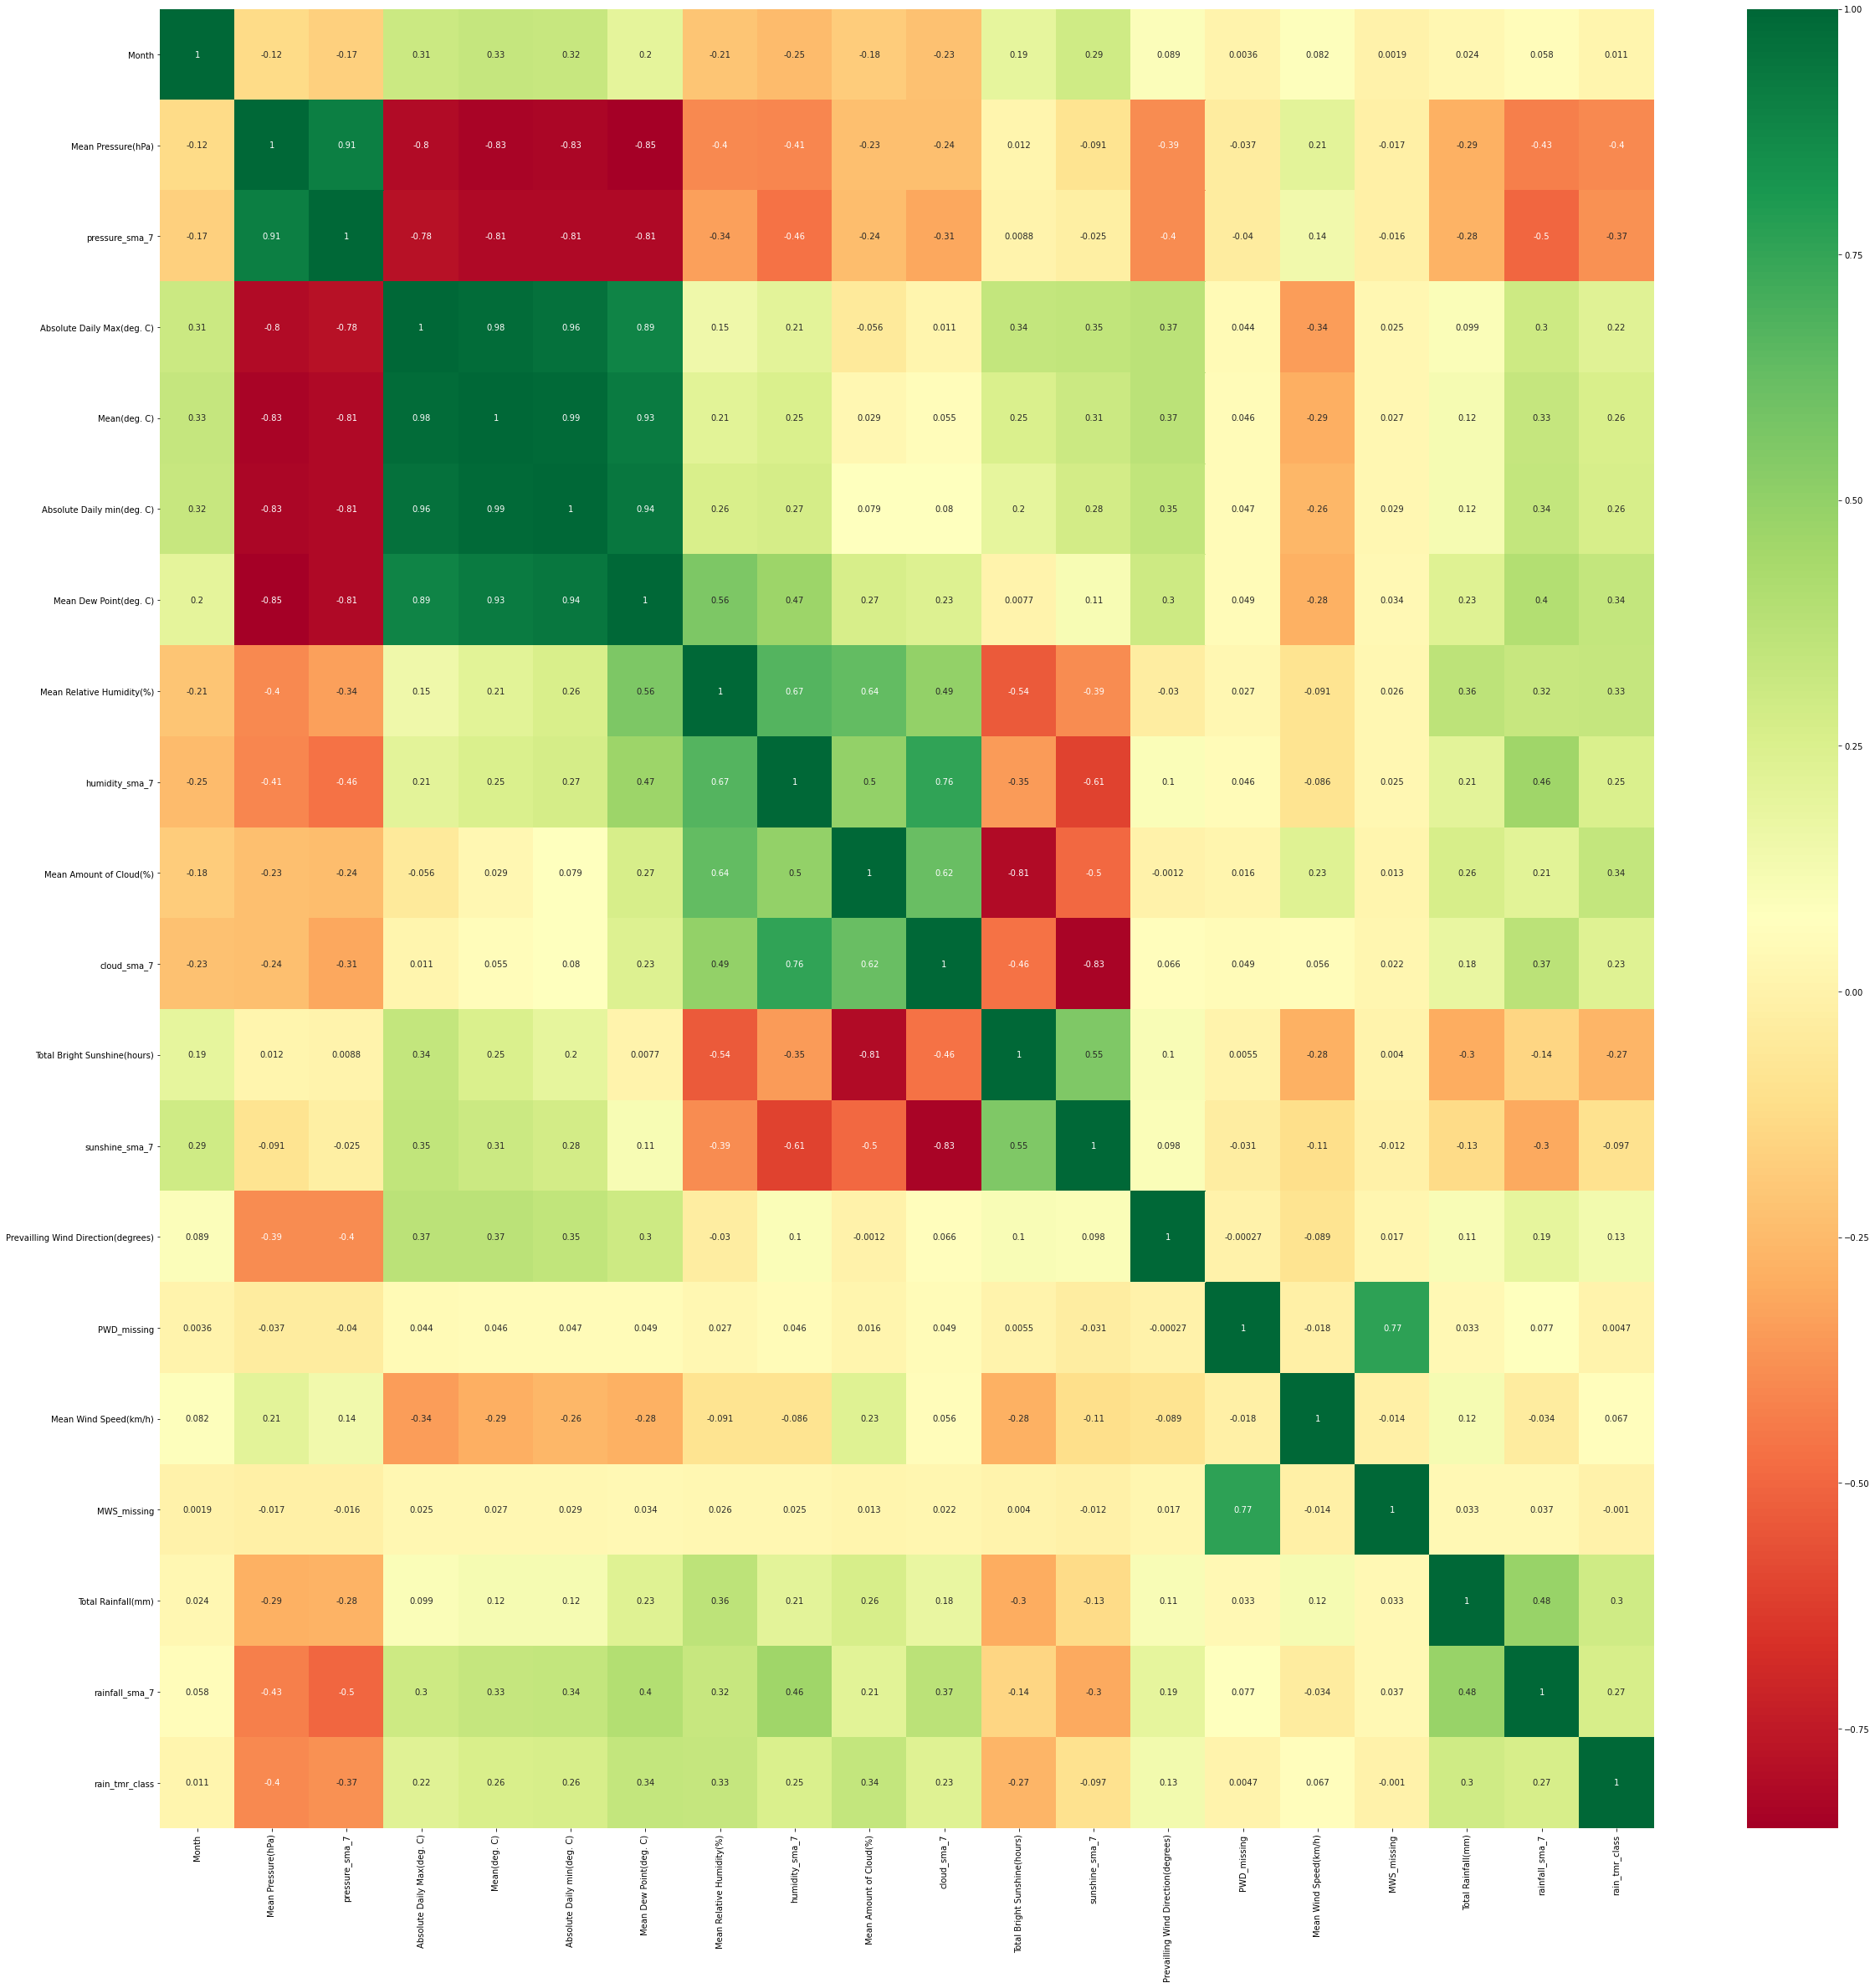

In [4]:
train=pd.concat([X_train,y_train],axis=1)
test=pd.concat([X_test,y_test],axis=1)
data=pd.concat([train,test],axis=0)
data.drop(columns='rain_tmr_mm',inplace=True)
plt.figure(figsize=(40,40))
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn')

In [5]:
#drop unwanted columns
X_train.drop(columns=['wind_direction','Absolute Daily Max(deg. C)','Absolute Daily min(deg. C)'],inplace=True)
X_test.drop(columns=['wind_direction','Absolute Daily Max(deg. C)','Absolute Daily min(deg. C)'],inplace=True)
y_train.drop(columns='rain_tmr_mm',inplace=True)
y_test.drop(columns='rain_tmr_mm',inplace=True)

### GridSearchCV

In [ ]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.03,0.05], #so called `eta` value
              'max_depth': range(4,8),
              'min_child_weight': range(4,8),
              'subsample': [0.5,0.6,0.7,0.8],
              'n_estimators': range(5,12),#number of trees, change it to 1000 for better results
              'reg_lambda': [0.1,0.2]
             }

xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)


In [ ]:
clf.best_estimator_

In [ ]:
clf.best_score_

In [7]:
#base xgboost model 
xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=np.nan, monotone_constraints='()',
              n_estimators=8, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
              subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None)
xg_clf.fit(X_train, y_train)
y_hat=xg_clf.predict(X_test)
xg_clf.get_booster().get_score(importance_type="gain")


{'Total Rainfall(mm)': 152.89887106333336,
 'Mean Pressure(hPa)': 42.07089255761905,
 'Mean Amount of Cloud(%)': 16.05291266259259,
 'Mean(deg. C)': 8.445362733333335,
 'Mean Wind Speed(km/h)': 8.69782299625,
 'pressure_sma_7': 12.737215182857145,
 'Mean Dew Point(deg. C)': 7.6825784404999995,
 'Mean Relative Humidity(%)': 6.360842142,
 'sunshine_sma_7': 12.00048468,
 'cloud_sma_7': 5.67017365,
 'Total Bright Sunshine(hours)': 10.7209007875,
 'Month': 7.35891795,
 'humidity_sma_7': 8.18191528}

In [10]:
xg_clf.get_booster().get_score(importance_type="weight")

{'Total Rainfall(mm)': 18,
 'Mean Pressure(hPa)': 21,
 'Mean Amount of Cloud(%)': 27,
 'Mean(deg. C)': 6,
 'Mean Wind Speed(km/h)': 8,
 'pressure_sma_7': 7,
 'Mean Dew Point(deg. C)': 12,
 'Mean Relative Humidity(%)': 5,
 'sunshine_sma_7': 2,
 'cloud_sma_7': 1,
 'Total Bright Sunshine(hours)': 4,
 'Month': 2,
 'humidity_sma_7': 1}

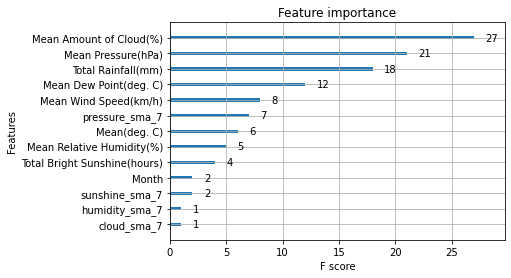

In [11]:
xgb.plot_importance(xg_clf)

cm: [[947  97]
 [187 210]]
Accuracy: 80.29%
f1: 0.5965909090909091
roc_auc: 0.7180276885067123


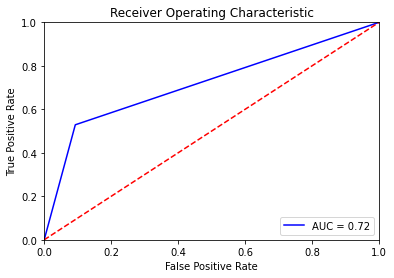

In [12]:
def print_metrics(y_test,y_hat):
    cm = confusion_matrix(y_test,y_hat)
    accuracy = accuracy_score(y_test, y_hat)
    f1 = f1_score(y_test,y_hat)
    roc_auc = roc_auc_score(y_test,y_hat)
    print('cm:',cm)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print('f1:',f1)
    print('roc_auc:',roc_auc)

    fpr, tpr, threshold = roc_curve(y_test, y_hat)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
print_metrics(y_test,y_hat)

### data without randomization

In [13]:
X_train=pd.read_csv('data/train/f_hk_train_to.csv')
X_train.set_index('Date',drop=True,inplace=True)
y_train=pd.read_csv('data/train/t_hk_train_to.csv')
y_train.set_index('Date',drop=True,inplace=True)
X_test=pd.read_csv('data/test/f_hk_test_to.csv')
X_test.set_index('Date',drop=True,inplace=True)
y_test=pd.read_csv('data/test/t_hk_test_to.csv')
y_test.set_index('Date',drop=True,inplace=True)

In [14]:
X_train.drop(columns=['wind_direction','Absolute Daily Max(deg. C)','Absolute Daily min(deg. C)'],inplace=True)
X_test.drop(columns=['wind_direction','Absolute Daily Max(deg. C)','Absolute Daily min(deg. C)'],inplace=True)
y_train.drop(columns='rain_tmr_mm',inplace=True)
y_test.drop(columns='rain_tmr_mm',inplace=True)

cm: [[927  72]
 [221 221]]
Accuracy: 79.67%
f1: 0.6013605442176871
roc_auc: 0.713963963963964


/Users/Hei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


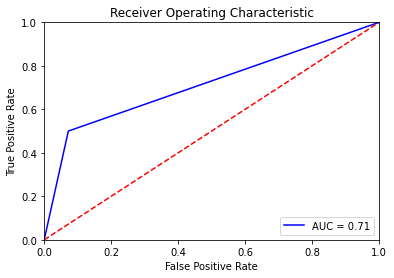

In [15]:
xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=np.nan, monotone_constraints='()',
              n_estimators=8, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
              subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None)

xg_clf.fit(X_train, y_train)
y_hat=xg_clf.predict(X_test)
print_metrics(y_test,y_hat)


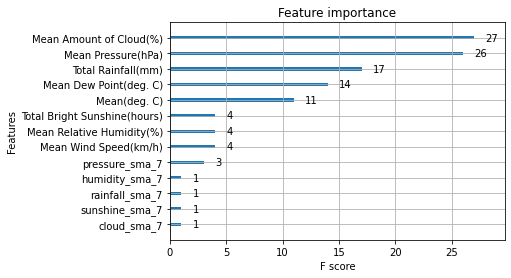

In [16]:
xgb.plot_importance(xg_clf)

In [17]:
xg_clf.get_booster().get_score(importance_type="gain")

{'Total Rainfall(mm)': 140.74073757352943,
 'Mean Pressure(hPa)': 42.31974904615384,
 'Mean Amount of Cloud(%)': 19.972155977777774,
 'Mean Dew Point(deg. C)': 7.289319884428571,
 'Mean Wind Speed(km/h)': 9.571241125,
 'Mean Relative Humidity(%)': 10.24667883,
 'Mean(deg. C)': 6.537531467272728,
 'cloud_sma_7': 9.59543228,
 'pressure_sma_7': 8.49831262,
 'Total Bright Sunshine(hours)': 12.6067233,
 'sunshine_sma_7': 4.91911459,
 'rainfall_sma_7': 4.53543091,
 'humidity_sma_7': 5.23366928}

### Using data with common columns as AUS

In [18]:
df_common = pd.read_csv('data/weather_hk_with_common.csv')
df_common

,Month,Mean Pressure(hPa),Absolute Daily Max(deg. C),Mean(deg. C),Absolute Daily min(deg. C),Mean Relative Humidity(%),Mean Amount of Cloud(%),Total Bright Sunshine(hours),Mean Wind Speed(km/h),Total Rainfall(mm),rain_tmr_mm,rain_tmr_class
0,1,1017.1,22.7,19.2,17.2,69,6,9.8,12.0,0.0,0.0,0
1,1,1017.2,23.6,20.4,17.8,64,2,9.3,9.0,0.0,0.0,0
2,1,1016.8,20.5,19.2,18.2,67,10,9.0,26.0,0.0,0.0,0
3,1,1016.1,20.5,18.9,17.5,74,60,3.9,25.0,0.0,0.0,0
4,1,1013.9,23.2,20.6,18.3,75,40,6.7,16.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7199,12,1020.3,21.3,18.0,15.6,65,23,9.4,32.0,0.0,0.0,0
7200,12,1020.2,20.9,18.5,16.8,72,64,6.1,28.0,0.0,9.3,1
7201,12,1018.3,19.6,18.8,17.9,88,92,0.0,22.0,9.3,0.3,0
7202,12,1020.0,22.5,20.3,18.8,91,90,0.0,22.0,0.3,0.0,0


In [19]:
train_size = int(df_common.shape[0]*0.8)
features=df_common.iloc[:,:-2]
target=df_common.iloc[:,-1:]

X_train=features[:train_size]
X_test=features[train_size:]
y_train=target[:train_size]
y_test=target[train_size:]


cm: [[925  74]
 [223 219]]
Accuracy: 79.39%
f1: 0.5959183673469388
roc_auc: 0.710700519524049


/Users/Hei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


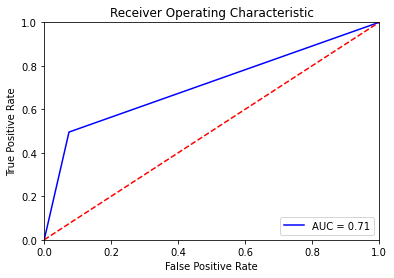

In [20]:
xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=np.nan, monotone_constraints='()',
              n_estimators=8, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
              subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None)

xg_clf.fit(X_train, y_train)
y_hat=xg_clf.predict(X_test)
print_metrics(y_test,y_hat)

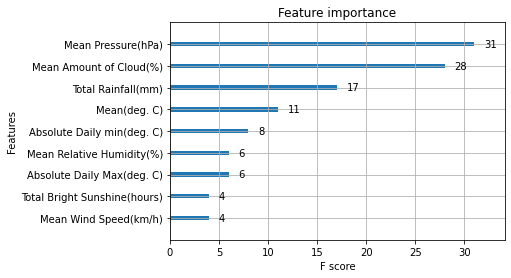

In [21]:
xgb.plot_importance(xg_clf)